In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model, metrics
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import torch
import torch.utils.data as data_utils
import sys
from tqdm import tqdm
from utils import *
sys.path.insert(0, '../VAE')
sys.path.insert(0, '.')
#from hdf_dataset import HDFDataset
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.neural_network import MLPClassifier

# Preprocessing
We normalize the features, shuffle it and create a training-test split. In addition I check the effect of second order polynomial features.

In [2]:
POLY_DEG = 1
NORMALIZE = False
DATASET_DIR = "/Users/rotem/PycharmProjects/NAF/external_maf/datasets/data/lhc"
DATASET_PATH_TEMPLATE = "{}/{}"
df = pd.read_hdf(DATASET_PATH_TEMPLATE.format(DATASET_DIR, "events_anomalydetection_v2.features.h5"))
y = df["label"]
signal = y == 1
delta_mj = np.abs(df['mj1'] - df['mj2'])
mjj = get_mjj(df)
epsilon = 1e-5
tau_21j1 = (df['tau2j1'] / df['tau1j1']).fillna(0) + epsilon
tau_21j2 = (df['tau2j2'] / df['tau1j2']).fillna(0) + epsilon
mass_order = df['mj1'] >= df['mj2']
df['m1'] = np.nan
df['m1'][mass_order] = df['mj1'][mass_order]
df['m1'][~mass_order] = df['mj2'][~mass_order]
df['m2'] = np.nan
df['m2'][mass_order] = df['mj2'][mass_order]
df['m2'][~mass_order] = df['mj1'][~mass_order]
df['tau^1_21'] = np.nan
df['tau^1_21'][mass_order] = tau_21j1[mass_order]
df['tau^1_21'][~mass_order] = tau_21j2[~mass_order]
df['tau^2_21'] = np.nan
df['tau^2_21'][mass_order] = tau_21j2[mass_order]
df['tau^2_21'][~mass_order] = tau_21j1[~mass_order]

X = df.loc[:, df.columns != "label"]
if NORMALIZE:
    mean = X.mean()
    std = X.std()
    X = (X - mean) / std
poly = PolynomialFeatures(POLY_DEG)
X = pd.DataFrame(poly.fit_transform(X), columns=poly.get_feature_names(X.columns))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
df.describe()

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2,label,m1,m2,tau^1_21,tau^2_21
count,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06
mean,-1.327996e+00,2.602047e+00,1.200619e-01,2.195990e+02,1.363843e+02,5.571819e+01,3.742071e+01,1.132151e+00,-2.496534e+00,-8.540738e-01,2.089902e+02,1.290355e+02,5.338557e+01,3.605997e+01,9.090909e-02,3.013525e+02,1.272367e+02,4.666487e-01,5.688340e-01
std,1.001400e+03,1.001730e+03,1.153441e+03,1.647181e+02,1.382575e+02,4.940572e+01,2.998556e+01,8.847728e+02,8.851543e+02,1.163099e+03,1.527055e+02,1.286603e+02,4.670867e+01,2.837653e+01,2.874799e-01,1.680407e+02,8.432954e+01,2.003078e-01,1.809020e-01
min,-3.880100e+03,-3.320690e+03,-5.587720e+03,-2.642900e-05,0.000000e+00,0.000000e+00,0.000000e+00,-3.740480e+03,-3.406180e+03,-5.490730e+03,-3.411970e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.647360e+01,-3.411970e-05,1.000000e-05,1.000000e-05
25%,-9.695655e+02,-9.663385e+02,-7.231380e+02,9.768073e+01,4.287708e+01,2.281695e+01,1.619798e+01,-7.972635e+02,-8.014985e+02,-7.380858e+02,9.543755e+01,4.065460e+01,2.221150e+01,1.605428e+01,0.000000e+00,1.652480e+02,7.014385e+01,3.085889e-01,4.436737e-01
50%,-1.785130e+00,5.091580e+00,1.598670e+00,1.629155e+02,8.372715e+01,4.143035e+01,2.934835e+01,2.593420e+00,-5.038455e+00,2.205830e-01,1.597260e+02,8.109740e+01,3.981480e+01,2.856560e+01,0.000000e+00,2.652320e+02,1.050140e+02,4.776385e-01,5.899505e-01
75%,9.659120e+02,9.702918e+02,7.237895e+02,2.998730e+02,1.776495e+02,7.149420e+01,4.973332e+01,8.002305e+02,7.979622e+02,7.365130e+02,2.836275e+02,1.699862e+02,6.866177e+01,4.770973e+01,0.000000e+00,4.226780e+02,1.575040e+02,6.233151e-01,7.062304e-01
max,3.852430e+03,3.484770e+03,6.155580e+03,1.615690e+03,1.473960e+03,7.564940e+02,4.504640e+02,3.630150e+03,3.295420e+03,5.620940e+03,1.508690e+03,1.464820e+03,7.450410e+02,4.914610e+02,1.000000e+00,1.615690e+03,1.197800e+03,9.901984e-01,9.939094e-01


In [ ]:
from sklearn.decomposition import FastICA, PCA
normalized_decorrelated_df = df[['m1', 'm2', 'tau^1_21', 'tau^2_21']]
def svd_whiten(X):
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    # U and Vt are the singular matrices, and s contains the singular values.
    # Since the rows of both U and Vt are orthonormal vectors, then U * Vt
    # will be white
    print(U)
    print(Vt)
    X_white = np.dot(U, Vt)
    return X_white

X_norm = normalized_decorrelated_df.to_numpy()
X_norm = (X_norm - X_norm.mean(axis=0))/X_norm.std(axis=0)
X_norm = svd_whiten(X_norm)
ica = FastICA(random_state=42)
ica.fit(X_norm)
X_norm = ica.transform(X_norm)
print(ica.components_)
X_norm = (X_norm - X_norm.mean(axis=0))/X_norm.std(axis=0)
plt.hist2d(X_norm[:, 1], X_norm[:, 2], bins=[50,50], norm=mpl.colors.LogNorm())
print()

## Visualization
Below I present histograms for all of the features.
Polynomial features seem to improve signal-bg separation.

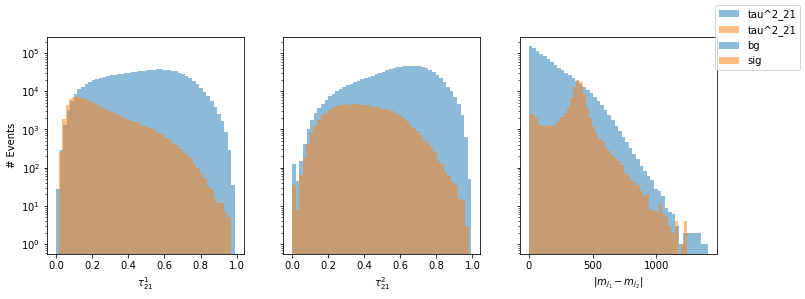

In [36]:
fig, axs = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(12, 4)
epsilon = 10**-5
alpha = 0.5
delta_mj = np.abs(df['mj1'] - df['mj2'])
axs[2].hist(delta_mj[~signal], label='bg', bins=50, alpha=0.5)
axs[2].hist(delta_mj[signal], label='sig', bins=50, alpha=0.5)
axs[2].set_yscale('log')
axs[2].set_xlabel("$|m_{j_1} - m_{j_2}|$")
axs[0].hist(df['tau^1_21'][~signal].to_numpy(), bins=50, alpha=0.5)
axs[0].hist(df['tau^1_21'][signal].to_numpy(), bins=50, alpha=0.5)
axs[0].set_yscale('log')
axs[0].set_xlabel("$\\tau^{1}_{21}$")
axs[1].hist(df['tau^2_21'][~signal], bins=50, alpha=0.5)
axs[1].hist(df['tau^2_21'][signal], bins=50, alpha=0.5)
axs[1].set_yscale('log')
axs[1].set_xlabel("$\\tau^{2}_{21}$")
axs[0].set_ylabel('# Events')
fig.legend()
fig.savefig('observable_histograms.png', dpi=400)

Plots of all variables

In [ ]:
for column in X_test.columns:
    X_test.hist(column=column, bins=50)
    X_test[y_test == 1].hist(column=column, bins=50)

Correlation with label, a high absolute value means the feature is a good indicator of signal.
We see the polynomial features sometimes exceed the non-polynomial ones.

In [20]:
X.drop('1',axis=1, inplace=True)

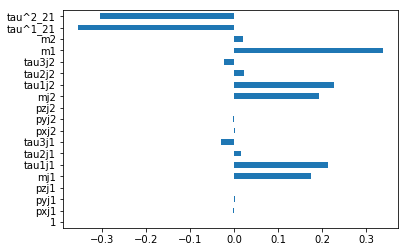

In [37]:
X.corrwith(y).plot(kind='barh')
plt.savefig('observable_correlations.png', dpi=400)

## PCA and further analysis
We see $\tau_{j_1}, \tau_{j_2}, m_{j_1}, m_{j_2}$ contains the most variance followed by $\vec{p}_{j_1}, \vec{p}_{j_2}$

             PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
1      -0.000000  0.000000  0.000000 -0.000000 -0.000000 -0.000000 -0.000000   
pxj1    0.289583 -0.691997 -0.014328 -0.000795 -0.000437  0.000073 -0.641751   
pyj1    0.692125  0.289517  0.000063 -0.003423 -0.000178 -0.000088  0.158979   
pzj1   -0.001732  0.012812 -0.685228  0.728214  0.000193 -0.000162 -0.000179   
mj1     0.000153  0.000134  0.000099 -0.000063  0.732616  0.170618 -0.000786   
tau1j1  0.000146  0.000055  0.000078 -0.000061  0.607740  0.148813 -0.000182   
tau2j1 -0.000012 -0.000015  0.000009 -0.000019  0.173732  0.043608  0.000267   
tau3j1 -0.000002  0.000007  0.000003 -0.000011  0.100120  0.023910  0.000106   
pxj2   -0.255036  0.609812  0.012692  0.000408 -0.000582  0.000137 -0.728282   
pyj2   -0.609907 -0.255216 -0.000008  0.002993  0.000042  0.000440  0.180241   
pzj2    0.008448 -0.012218  0.728077  0.685334 -0.000016 -0.000060 -0.000114   
mj2     0.000244  0.000027 -0.000084  0.

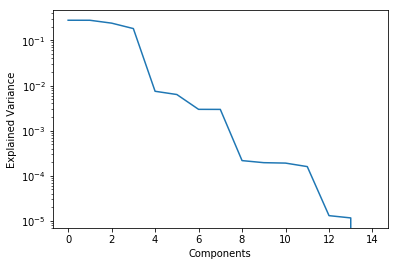

In [6]:
pca = PCA(n_components=X.shape[1])
pca.fit(X)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
                        columns=['PC%s' % _ for _ in range(len(X.columns))],
                        index=X.columns)
print(loadings)

plt.plot(pca.explained_variance_ratio_)
plt.yscale('log')
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

Rotating into the PCs we see the PCs that differentiate well between signal and background: 1, 6, 8, 10, 11

/Users/rotem/opt/anaconda3/envs/NAF/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


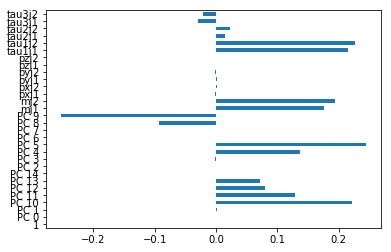

In [7]:
X_pca = pd.DataFrame(data=pca.transform(X), columns=["PC {}".format(i) for i in range(len(X.columns))])
pd.concat([X, X_pca]).corrwith(y).plot(kind='barh')
#plt.plot(np.linspace(0, X.shape[1]-1, X.shape[1]), np.abs(np.corrcoef(X_pca.T, y)[:-1, -1]), '.')
#plt.xlabel("PC")
#plt.ylabel(r"$|\rho|$")
#plt.yscale('log')

## Linear classifier test
To assess the quality of the features we use we can check how well a linear classifier fits the label of the training set to them.

Some simple NNs and decision trees are tested for reference.

When successful, this means that the non-linearity differentiating between the signal and background is captured by the features.

In [16]:
models = {"Linear_1e-5": linear_model.SGDClassifier(alpha=1e-5)}
#          "BDT_1_100":  AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=100),
#          "MLP_10_10": MLPClassifier(hidden_layer_sizes=(10, 10)),
#          "MLP_5_5": MLPClassifier(hidden_layer_sizes=(5, 5))}

for name in models:
    models[name].fit(X_train, y_train)

A ROC curve is used to evaluate the effectiveness of the classification.

Linear_1e-5: 0.0864454545455


Text(0,0.5,'TPR')

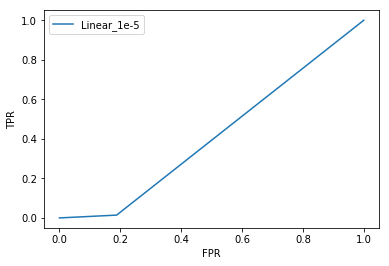

In [18]:
for name in models:
    model = models[name]
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    print(f"{name}: {mse}")
    tpr, fpr, thresh = metrics.roc_curve(y_test, model.predict(X_test))
    plt.plot(fpr, tpr, label=name)
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")

# VAE
Now lets give it a go using a $\beta$-VAE.

In [3]:
from beta1_vae_model import *
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10**8
model_cp_path_format = 'models/vae_lhc_410103_preprocess_nsig{}.pt'
cols = ['vae410103 kld nsig{}'.format(10**i) for i in range(2,6)]
scores = pd.read_csv('external_maf/datasets/data/lhc/lhc_vae_density.csv')

In [4]:
scores.describe()

,vae141263 density 5of10,vae141263 kld 5of10,vae141263 density 6of10,vae141263 kld 6of10,vae141263 density 7of10,vae141263 kld 7of10,vae141263 density 8of10,vae141263 kld 8of10,vae141263 density 9of10,vae141263 kld 9of10,vae141263 density 10of10,vae141263 kld 10of10,vae141263 density nsig100,vae141263 kld nsig100,vae141263 density nsig1000,vae141263 kld nsig1000,vae141263 density nsig10000,vae141263 kld nsig10000,vae141263 density nsig100000,vae141263 kld nsig100000
count,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06
mean,-2.999032e+00,5.628827e-08,-2.999114e+00,1.023131e-08,-2.998193e+00,2.260082e-08,-2.997749e+00,3.077999e-08,-2.999045e+00,4.538501e-09,-3.001985e+00,1.024063e-08,-2.997840e+00,2.725451e-08,-3.000636e+00,-3.926421e-08,-2.997270e+00,-9.060393e-09,-2.998948e+00,-1.735123e-10
std,2.448039e+00,4.813761e-06,2.450249e+00,1.583177e-06,2.447818e+00,9.313357e-07,2.448246e+00,2.813955e-06,2.447597e+00,7.562911e-08,2.452999e+00,6.637124e-07,2.450353e+00,9.838581e-07,2.451227e+00,1.314626e-09,2.447059e+00,3.502870e-09,2.447422e+00,1.379611e-11
min,-3.063502e+01,-6.426087e-08,-3.443850e+01,-7.302212e-08,-3.049955e+01,-8.933785e-08,-3.314287e+01,-8.348693e-08,-3.549803e+01,-8.894825e-08,-3.472041e+01,-8.894008e-08,-3.051819e+01,2.631644e-08,-3.274018e+01,-5.499974e-08,-3.275217e+01,-2.403798e-08,-2.931702e+01,-2.192132e-10
25%,-4.106386e+00,-1.676091e-08,-4.108393e+00,-1.276879e-08,-4.105987e+00,-9.295132e-09,-4.103463e+00,-1.295840e-08,-4.106506e+00,-1.279386e-08,-4.106746e+00,-1.583162e-08,-4.102362e+00,2.631644e-08,-4.111928e+00,-3.993133e-08,-4.104001e+00,-1.142296e-08,-4.108386e+00,-1.822901e-10
50%,-2.365020e+00,-1.861621e-09,-2.365403e+00,1.439589e-09,-2.363318e+00,9.119969e-09,-2.363571e+00,1.870059e-09,-2.365052e+00,2.326008e-09,-2.368900e+00,2.808310e-09,-2.362957e+00,2.631644e-08,-2.367078e+00,-3.911064e-08,-2.364334e+00,-8.882914e-09,-2.364735e+00,-1.743527e-10
75%,-1.211596e+00,1.397166e-08,-1.211105e+00,1.589582e-08,-1.211749e+00,2.794314e-08,-1.212026e+00,1.501477e-08,-1.214083e+00,1.863395e-08,-1.212180e+00,2.188766e-08,-1.212529e+00,2.631644e-08,-1.213020e+00,-3.842704e-08,-1.211944e+00,-6.529953e-09,-1.212224e+00,-1.659246e-10
max,-1.735768e-04,2.193755e-03,-2.474088e-04,1.212015e-03,-7.575485e-04,2.731370e-04,-1.620966e-04,1.556361e-03,-5.326990e-04,4.668808e-05,-1.360125e-05,5.818525e-04,-5.387491e-04,1.031905e-03,-4.333371e-04,-3.606386e-08,-6.624212e-05,-3.297221e-09,-1.234958e-04,-3.195844e-11


Load and get scores

[[-0.9320293   0.15919153 -0.30587393 -0.11144766]
 [-0.17191724 -0.97736892 -0.02851506  0.1199223 ]
 [-0.09133917  0.13735741 -0.00954283  0.98625505]
 [ 0.30565178 -0.02325941 -0.95159706  0.02233895]]


100%|██████████| 1/1 [00:05<00:00,  5.29s/it]


count    1.100000e+06
mean     1.935063e-10
std      1.609388e-07
min     -8.288457e-08
25%     -1.589253e-08
50%     -4.320100e-12
75%      1.588780e-08
max      1.629331e-04
Name: vae410103 kld nsig1000, dtype: float64

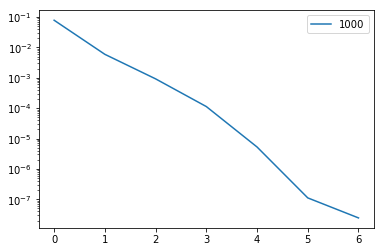

In [7]:
dataset = NumpyDataset(preprocess_dataframe(df[['m1', 'm2', 'tau^1_21', 'tau^2_21']]))
dataloader = data_utils.DataLoader(dataset, batch_size=dataset.length, shuffle=False)
for i in tqdm([10**j for j in range(3, 4)]):
    model, _, losses, _ = load(model_cp_path_format.format(i))#, [14, 12, 6, 3], 1.e-5)
    model.eval()
    _, mask = get_n_signal_dataset(i, df)
    scores['vae410103 mask nsig{}'.format(i)] = np.logical_and(mask, signal)
    losses = np.array(losses)
    losses[losses <= 0] = 10**-11
    mean_losses = [np.mean(losses[10000*k:10000*(k+1)]) for k in range(losses.shape[0] / 10000)]
    plt.plot(mean_losses, label=str(i))
    for x in dataloader:
        scores['vae410103 kld nsig{}'.format(i)] = model.get_losses(x).detach().numpy()
plt.legend()
plt.yscale('log')
scores[cols[1]].describe()

In [10]:
scores.to_csv('external_maf/datasets/data/lhc/lhc_vae_density.csv')

# events in cut: 66000
% signal: 0.109691304055
% original signal: 0.0012105723317


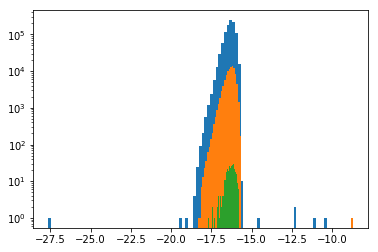

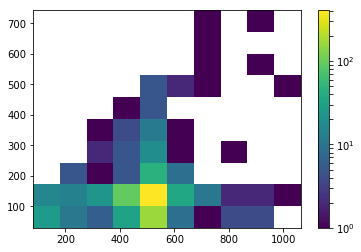

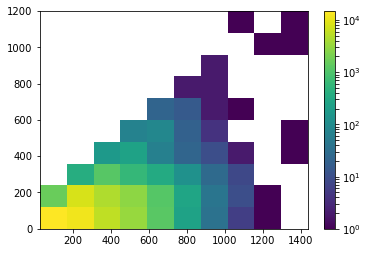

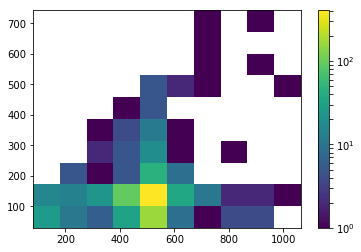

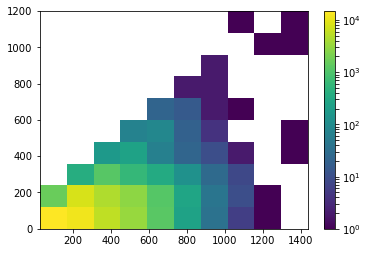

In [26]:
i = 1
anomally_score = scores[cols[i]]
anomally_score = anomally_score - anomally_score.min() + 1e-12
anomally_score = np.log(anomally_score)
original_sig = scores['vae410103 mask nsig{}'.format(10**(i+2))]

plt.hist(anomally_score[~signal], bins=100, label='bg')
plt.hist(anomally_score[signal], bins=100, label='sig')
plt.hist(anomally_score[original_sig], bins=100)
plt.yscale('log')
cut = anomally_score >= anomally_score.quantile(0.94)

print("# events in cut: {}".format(np.sum(cut)))
print("% signal: {}".format(1.0 * np.sum(np.logical_and(cut, signal)) / np.sum(np.logical_and(cut, ~signal))))
print("% original signal: {}".format(1.0 * np.sum(np.logical_and(cut, original_sig)) / np.sum(np.logical_and(cut, ~signal))))
cut = cut & (~signal | original_sig)
plot_mj(df, original_sig, cut, bins=[10,10])
plot_params(df['m1'], df['m2'], original_sig, cut, bins=[10, 10])

In [15]:
scores[cols[i]].describe()

count    1.100000e+06
mean     1.935063e-10
std      1.609388e-07
min     -8.288457e-08
25%     -1.589253e-08
50%     -4.320100e-12
75%      1.588780e-08
max      1.629331e-04
Name: vae410103 kld nsig1000, dtype: float64

100%|██████████| 100/100 [00:03<00:00, 31.48it/s]


Cut quantile: 0.94 
Signal percent: 0.00121545121545
Bin signal percent: 0.000999000999001


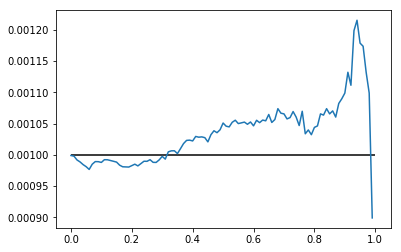

In [28]:
plot_cuts(anomally_score, original_sig | ~signal, original_sig, 100)

In [ ]:
template = 'vae141263 density nsig{}'
for i in [10**j for j in range(2,6)]:
    plt.figure()
    plt.hist(scores[template.format(i)][~signal], bins=50)
    plt.hist(scores[template.format(i)][signal], bins=50)
    plt.hist(scores[template.format(i)][scores['vae141263 mask nsig{}'.format(i)]], bins=50)
    plt.title(i)
    plt.yscale('log')
ratio = scores[template.format(10**5)] - scores[template.format(10**3)]
plt.figure()
plt.hist(ratio[~signal], bins=50)
plt.hist(ratio[signal], bins=50)
plt.yscale('log')

In [10]:
scores.to_csv('external_maf/datasets/data/lhc/lhc_vae_density.csv', index=False)

count    1.160000e+02
mean     2.692701e-06
std      6.740688e-06
min      4.046829e-07
25%      4.798613e-07
50%      7.756081e-07
75%      1.640328e-06
max      4.455743e-05
Name: vae141263 kld 7of10, dtype: float64


0.2413793103448276

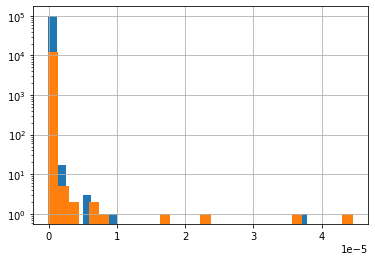

In [112]:
bin_num = 7
scores['vae141263 kld {}of10'.format(bin_num)][np.logical_and(~signal, df['mjj_bin_num'] == bin_num)].hist(bins=30)
scores['vae141263 kld {}of10'.format(bin_num)][np.logical_and(signal, df['mjj_bin_num'] == bin_num)].hist(bins=30)
plt.yscale('log')
united = pd.concat([df, scores], axis=1)
cut = np.logical_and(df['mjj_bin_num'] == bin_num, scores['vae141263 kld {}of10'.format(bin_num)] >= 4e-7)
print(scores['vae141263 kld {}of10'.format(bin_num)][cut].describe())
np.sum(df['label'][cut]) / np.sum(cut)

## Creating bins and datasets
We create the different bins from the data for training purposes, $m_{jj}$ is chosen as the discriminatory variable

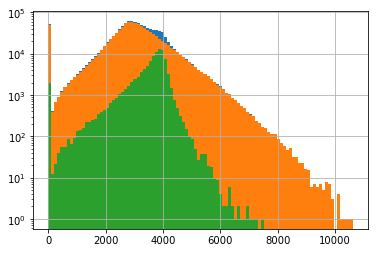

In [34]:
signal = df['label'] == 1
mjj = get_mjj(df)
mjj = mjj / mjj[signal].mean() * 3500  # seems not to match the expected value for some reason so I fixed it
_, bins, _ = plt.hist(mjj, bins=100)
mjj[~signal].hist(bins=bins)
mjj[signal].hist(bins=bins)
plt.yscale('log')

In [41]:
mjj[signal].describe()

count    100000.000000
mean       3500.000000
std         783.235144
min           0.000000
25%        3320.840690
50%        3726.469411
75%        3939.212542
max        7463.293337
dtype: float64

In [57]:
q = 7
nsig = 1000
df["mjj_bins"] = pd.qcut(mjj, q=q, precision=100)
df["mjj_bin_num"] = pd.qcut(mjj, q=q, labels=[i for i in range(1, q + 1)])
_, lower_sig_mask = get_n_signal_dataset(nsig, df.drop('mjj_bins', axis=1))
df["mjj_bins"].unique()

[(3575.31996215, 4032.89349752], (2909.69826896, 3202.27416104], (3202.27416104, 3575.31996215], (2107.51574579, 2622.07202813], (4032.89349752, 10605.6093931], (2622.07202813, 2909.69826896], (-1e-100, 2107.51574579]]
Categories (7, interval[float64]): [(-1e-100, 2107.51574579] < (2107.51574579, 2622.07202813] < (2622.07202813, 2909.69826896] < (2909.69826896, 3202.27416104] < (3202.27416104, 3575.31996215] < (3575.31996215, 4032.89349752] < (4032.89349752, 10605.6093931]]

In [58]:
# Need to make sure it is done with python 2.7 for unpickle to work
ds  = preprocess_dataframe(df[['m1', 'm2', 'tau^1_21', 'tau^2_21']])
for i in range(int(q / 2), q + 1):
    x = ds[(df['mjj_bin_num'] == i) & lower_sig_mask]
    #x = df[np.logical_and(df["mjj_bin_num"] == i, lower_sig_mask)].to_numpy()[:, :14]
    print(x.shape[0])
    print(np.sum((df['mjj_bin_num'] == i) & lower_sig_mask & signal))
    np.save("external_maf/datasets/data/lhc/lhc_mjj_bin_{}of{}.npy".format(i, q), x, allow_pickle=True)
df.to_csv("external_maf/datasets/data/lhc/lhc_features_and_bins.csv", index=False)

[[-0.9320293   0.15919153 -0.30587393 -0.11144766]
 [-0.17191724 -0.97736892 -0.02851506  0.1199223 ]
 [-0.09133917  0.13735741 -0.00954283  0.98625505]
 [ 0.30565178 -0.02325941 -0.95159706  0.02233895]]
152945
37
150220
65
140214
173
109824
481
142974
144


For sanity plotting the jet mass difference

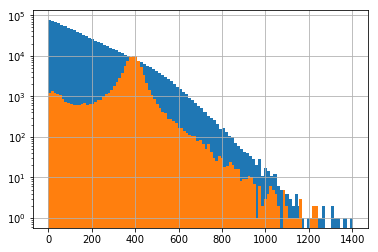

In [75]:
fig, ax = plt.subplots()

param = delta_mj
param[~signal].hist(bins=100)
param[signal].hist(bins=100)
plt.yscale('log')

# Testing the flow models in different bins
A plot of $R = \frac{p_{sig+bg}}{p_{bg}}$ should indicate which events are anomalous. In order to do this we add columns to the dataset for the models' density estimation for each event.

In [6]:
flow = "ddsf"
epochs = 40
original_sig = np.logical_and(signal, lower_sig_mask)
densities = pd.read_csv("external_maf/datasets/data/lhc/lhc_{}_density.csv".format(flow))
united = pd.concat([df, densities], axis=1)
column_template = 'lhc_binned_en{}of{}_sp0_e{}_s1993_p0.0_h100_f{}_fl5_l1_dsdim16_dsl1_cudaFalse_best'.format('{}', q, epochs, flow)
#column_template = 'lhc_binned_en{}of{}_sp0_e400_s1993_p0.0_h100_faffine_fl5_l1_dsdim16_dsl1_cudaFalse_best'.format('{}', q)
#column_template = 'vae141263 density {}of10'

In [157]:
densities.describe()

,lhc_binned_en2of5_sp0_e40_s1993_p0.0_h100_fddsf_fl5_l1_dsdim16_dsl1_cudaFalse_best,lhc_binned_en3of5_sp0_e40_s1993_p0.0_h100_fddsf_fl5_l1_dsdim16_dsl1_cudaFalse_best,lhc_binned_en4of5_sp0_e40_s1993_p0.0_h100_fddsf_fl5_l1_dsdim16_dsl1_cudaFalse_best,lhc_binned_en5of5_sp0_e40_s1993_p0.0_h100_fddsf_fl5_l1_dsdim16_dsl1_cudaFalse_best,lhc_binned_en4of8_sp0_e40_s1993_p0.0_h100_fddsf_fl5_l1_dsdim16_dsl1_cudaFalse_best,lhc_binned_en5of8_sp0_e40_s1993_p0.0_h100_fddsf_fl5_l1_dsdim16_dsl1_cudaFalse_best,lhc_binned_en6of8_sp0_e40_s1993_p0.0_h100_fddsf_fl5_l1_dsdim16_dsl1_cudaFalse_best,lhc_binned_en7of8_sp0_e40_s1993_p0.0_h100_fddsf_fl5_l1_dsdim16_dsl1_cudaFalse_best,lhc_binned_en8of8_sp0_e40_s1993_p0.0_h100_fddsf_fl5_l1_dsdim16_dsl1_cudaFalse_best
count,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.099999e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06
mean,-9.537423e+01,-9.693268e+01,-8.770266e+01,-9.546186e+01,-1.741940e+02,-9.869598e+01,-1.200885e+02,-9.553615e+01,-8.614049e+01
std,2.201893e+01,2.590317e+01,1.073898e+01,1.660688e+01,5.244989e+01,2.926868e+01,3.634761e+01,1.778260e+01,6.735929e+00
min,-5.066314e+02,-1.132025e+03,-3.887637e+02,-2.812537e+02,-8.753915e+02,-1.758498e+03,-1.305098e+03,-3.942980e+02,-2.885593e+02
25%,-1.037307e+02,-1.039896e+02,-9.326895e+01,-1.041030e+02,-2.065145e+02,-1.039545e+02,-1.330022e+02,-1.027323e+02,-9.039896e+01
50%,-8.826676e+01,-8.809504e+01,-8.554684e+01,-9.142802e+01,-1.787389e+02,-8.966481e+01,-1.189633e+02,-9.060059e+01,-8.590905e+01
75%,-8.014213e+01,-8.034600e+01,-8.018309e+01,-8.324253e+01,-1.343515e+02,-8.171025e+01,-1.006985e+02,-8.349297e+01,-8.143894e+01
max,-6.133057e+01,-6.156741e+01,-6.214296e+01,-6.256416e+01,-6.919833e+01,-6.163732e+01,-6.626727e+01,-6.284649e+01,-6.423238e+01


count    91989.000000
mean         4.008623
std          2.161920
min        -18.312203
25%          2.666306
50%          4.003072
75%          5.315303
max         73.623567
Name: lhc_binned_en7of8_sp0_e40_s1993_p0.0_h100_fddsf_fl5_l1_dsdim16_dsl1_cudaFalse_best, dtype: float64
count    446.000000
mean       4.340054
std        1.903226
min       -1.178059
25%        2.990422
50%        4.192873
75%        5.417956
max       10.120720
Name: lhc_binned_en7of8_sp0_e40_s1993_p0.0_h100_fddsf_fl5_l1_dsdim16_dsl1_cudaFalse_best, dtype: float64
count    100000.000000
mean          1.784391
std           6.521829
min         -87.444383
25%           1.172326
50%           3.364107
75%           4.940767
max          56.309297
Name: lhc_binned_en7of8_sp0_e40_s1993_p0.0_h100_fddsf_fl5_l1_dsdim16_dsl1_cudaFalse_best, dtype: float64


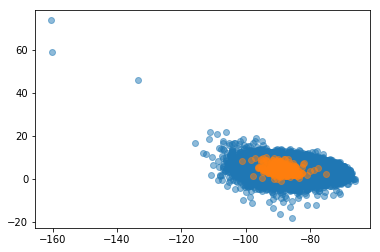

In [7]:
from scipy.special import logsumexp
signal_region = 7
log_psig = densities[column_template.format(signal_region)]
log_pbg = (logsumexp([densities[column_template.format(signal_region+1)], densities[column_template.format(signal_region-1)]], axis=0) - np.log(2))
#log_psig = np.mean([densities[column_template.format(sr)] for sr in signal_region], axis=0)
#log_pbg = 0.5 * (densities[column_template.format(max(signal_region) + 1)] + densities[column_template.format(min(signal_region) - 1)])
#log_psig = np.log(np.mean([np.exp(united[column_template.format(sr)]) for sr in signal_region], axis=0))
#log_pbg = np.log(0.5 * (np.exp(united[column_template.format(max(signal_region) + 1)]) + np.exp(united[column_template.format(min(signal_region) - 1)])))
#log_psig[log_psig == -np.inf] = -750.
#log_pbg[log_pbg == -np.inf] = -750.
logR = log_psig - log_pbg
logR.describe()
bin_mask = (df['mjj_bin_num'] == signal_region) & (~signal | original_sig)
# bin_mask = np.logical_and(lower_sig_mask, bin_mask)
plt.scatter(x=log_pbg[bin_mask & ~signal], y=logR[bin_mask & ~signal], alpha=0.5)
plt.scatter(x=log_pbg[bin_mask & original_sig], y=logR[bin_mask & original_sig], alpha=0.5)
#plt.yscale('log')
#plt.ylim(1e-10, 1e15)
print(logR[np.logical_and(~signal, bin_mask)].describe())
print(logR[np.logical_and(original_sig, bin_mask)].describe())
print(logR[signal].describe())

Events in cut: 1849
% signal in cut: 0.00757166035695
% signal in bin: 0.00482501217071


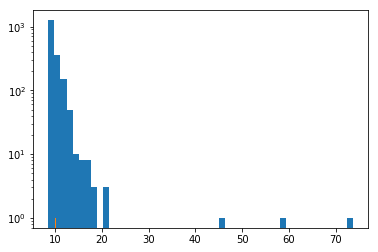

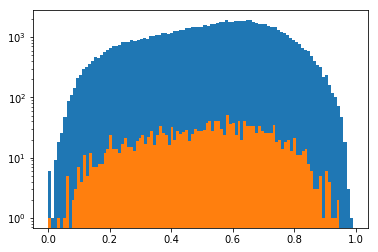

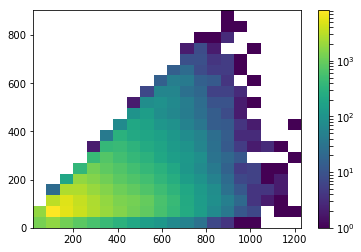

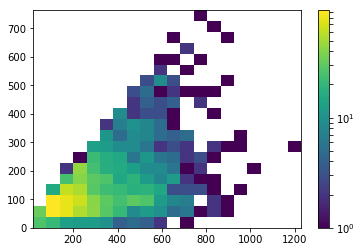

In [8]:
cut = (logR >= logR[bin_mask].quantile(0.98)) & bin_mask
print("Events in cut: {}".format(np.sum(cut)))
plt.hist(logR[cut], bins=50)
plt.hist(logR[np.logical_and(cut, signal)], bins=50)
plt.yscale('log')
print("% signal in cut: {}".format(np.sum(1.0*np.logical_and(cut, signal))/np.sum(cut)))
print("% signal in bin: {}".format(np.sum(1.0*np.logical_and(bin_mask, signal))/np.sum(bin_mask)))
plt.figure()
plt.hist(tau_21j2[bin_mask], bins=100)
plt.hist(tau_21j2[cut], bins=100)
plt.yscale('log')
plot_mj(df, bin_mask, cut, bins=[20,20])

100%|██████████| 1000/1000 [00:19<00:00, 52.26it/s]


Cut quantile: 0.981 
Signal percent: 0.00796812749004
Bin signal percent: 0.00482501217071


100%|██████████| 1000/1000 [00:19<00:00, 52.62it/s]


Cut quantile: 0.005 
Signal percent: 0.00484930196147
Bin signal percent: 0.00482501217071


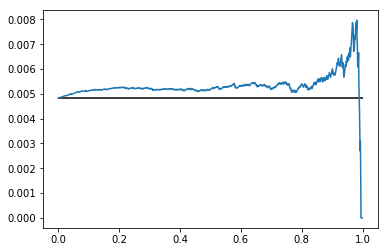

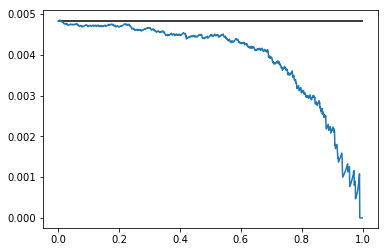

In [179]:
plot_cuts(logR, bin_mask, signal, 1000)
plot_cuts(-logR, bin_mask, signal, 1000)

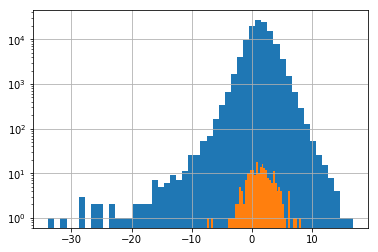

In [26]:
logR[~signal & bin_mask].hist(bins=50)
logR[signal & bin_mask].hist(bins=50)
plt.yscale('log')

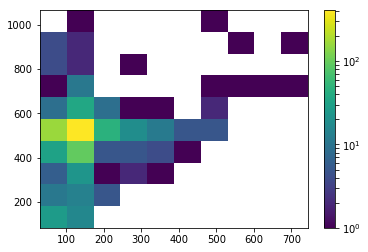

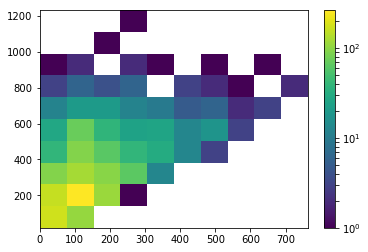

In [23]:
tau_ratios = pd.concat([tau_21j1, tau_21j2], axis=1)
mj = pd.concat([df['mj1'], df['mj2']], axis=1)
plot_params(mj.min(axis=1), mj.max(axis=1), original_sig, cut, bins=[10,10])

Signal/Total in cut: 1587.0/14538 = 0.10916219562525795


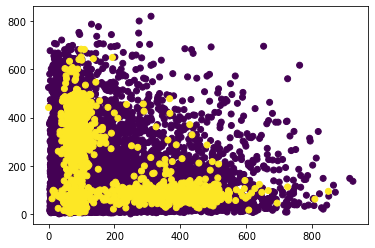

In [56]:
#cut = np.logical_and(logR >= 15, bin_mask)
cut = np.logical_and(logR >= 2, bin_mask)
total_cut = np.sum(cut)
signal_in_cut = np.sum(df['label'][cut])
ratio = signal_in_cut / total_cut
print("Signal/Total in cut: {}/{} = {}".format(signal_in_cut, total_cut, ratio))
plt.scatter(x=df['tau1j1'][cut], y=df['tau1j2'][cut], c=df['label'][cut])

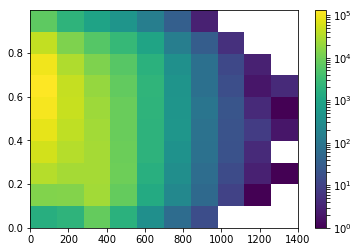

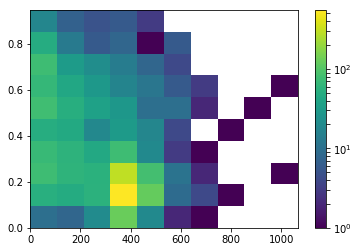

In [125]:
plt.figure()
plt.hist2d(x=delta_mj, y=tau_21j2, bins=[10, 10], norm=mpl.colors.LogNorm())
plt.colorbar()
plt.figure()
plt.hist2d(x=delta_mj[cut], y=tau_21j2[cut], bins=[10, 10], norm=mpl.colors.LogNorm())
plt.colorbar()